# Принятие решений в бизнесе

## Описание проекта

Необходимо приоритезировать гипотезы, созданные совместно с отделом маркетинга, запустить A/B-тест и проанализировать результаты.

## Цели и задачи проекта

- Приоритезация гипотез;
- узнать куммулятивные выручку и средний чек разных групп;
- сравнить показатели группы А и В;
- узнать есть ли аномальные значения в группах;
- сделать выводы о результатах теста и принять одно из возможных решений.

## Описание данных

Данные для первой части

Файл /datasets/hypothesis.csv.

- Hypothesis — краткое описание гипотезы;

- Reach — охват пользователей по 10-балльной шкале;

- Impact — влияние на пользователей по 10-балльной шкале;

- Confidence — уверенность в гипотезе по 10-балльной шкале;

- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные для второй части

Файл /datasets/orders.csv.

- transactionId — идентификатор заказа;

- visitorId — идентификатор пользователя, совершившего заказ;

- date — дата, когда был совершён заказ;

- revenue — выручка заказа;

- group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv.

- date — дата;

- group — группа A/B-теста;

- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## 1. Загрузка данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import warnings
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')
import datetime as dt

%matplotlib inline

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


In [ ]:
hipothesis = pd.read_csv('hypothesis.csv')
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

Посмотрим содержание файлов

In [ ]:
hipothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [ ]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [ ]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [ ]:
hipothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [ ]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Пропусков в данных нет, но столбец date в двух датафреймах имеет тип 'object', привелем его к типу 'datetime'. Также для удобства приведем названия столбцов датафрейма hipothesis к нижнему регистру.

In [ ]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
hipothesis.columns = hipothesis.columns.str.lower()

In [ ]:
orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'}, inplace=True)

Посмотрим сколько групп учавствует в тесте.

In [ ]:
orders.group.unique()

array(['B', 'A'], dtype=object)

In [ ]:
orders.agg({'date':['min', 'max']})

,date
min,2019-08-01
max,2019-08-31


In [ ]:
orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

In [ ]:
orders['transaction_id'].duplicated().sum()

0

In [ ]:
print(orders.duplicated().sum(), visitors.duplicated().sum())

0 0


In [ ]:
count_group = orders.groupby('visitor_id', as_index=False)[['visitor_id', 'group']].agg({'group':'nunique'})
# count_group.column = ['visitor_id', 'count_group']
count_group = count_group[count_group['group'] >= 2]
count_group.shape

(58, 2)

In [ ]:
orders[orders['visitor_id'] == 8300375]

,transaction_id,visitor_id,date,revenue,group
71,3679129301,8300375,2019-08-01,10510,B
703,4293855558,8300375,2019-08-07,1790,A


In [ ]:
list_filter = list(count_group['visitor_id'])
orders_filtered = orders.query('visitor_id not in @list_filter')

In [ ]:
orders_filtered['group'].value_counts()

B    548
A    468
Name: group, dtype: int64

In [ ]:
orders = orders_filtered

## Часть 1. Приоритизация гипотез.

### Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

Формула для расчета ICE:


\begin{align}
        ICE = \frac{impact * confidence} {efforts}
\end{align}


In [ ]:
hipothesis['ice'] = hipothesis['impact'] * hipothesis['confidence'] / hipothesis['efforts']
hipothesis.sort_values(by='ice', ascending=False, inplace=True)

In [ ]:
hipothesis

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


После приоритизации методом ICE на первое место вышла гипотеза под номером 8

### Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

Формула для расчета RICE:


\begin{align}
        RICE = \frac{reach * impact * confidence} {efforts}
\end{align}


In [ ]:
hipothesis['rice'] = hipothesis['reach'] * hipothesis['impact'] * hipothesis['confidence'] / hipothesis['efforts']
hipothesis.sort_values(by='rice', ascending=False, inplace=True)

In [ ]:
hipothesis

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


После приоритизации методом ICE на первое место вышла гипотеза под номером 7.

### Укажем, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясним, почему так произошло.

Различие в приоритетах гипотез заключается в том, что ICE не учитывает reach - — скольких пользователей затронет изменение, которое мы хотим внести. У гипотезы 7 максимально возможная оценка, остальные показатели также высоки. Параметр efforts - цена теста этой гипотезы не такой большой в сравнении с другими гипотезами, у которых высокие reach, impact и confidence.

## Часть 2. Анализ A/B-теста.

### 1. Построим график кумулятивной выручки по группам. Сделаем выводы и предположения.

In [ ]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [ ]:
date_group = orders[['date', 'group']].drop_duplicates()
orders_agg = date_group.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date': 'max',
                                                                                                                                'group': 'max',
                                                                                                                                'transaction_id': 'nunique',
                                                                                                                                'visitor_id': 'nunique',
                                                                                                                                'revenue': 'sum'}), axis=1).sort_values(by=['date', 'group'])
visitors_agg = date_group.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date': 'max',
                                                                                                                                'group': 'max',
                                                                                                                                'visitors': 'sum'}), axis=1).sort_values(by=['date', 'group'])
cumulative_data = orders_agg.merge(visitors_agg, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [ ]:
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


In [ ]:
cumulative_revenue_a = cumulative_data[cumulative_data['group'] == 'A'][['date', 'revenue', 'orders']]
cumulative_revenue_b = cumulative_data[cumulative_data['group'] == 'B'][['date', 'revenue', 'orders']]

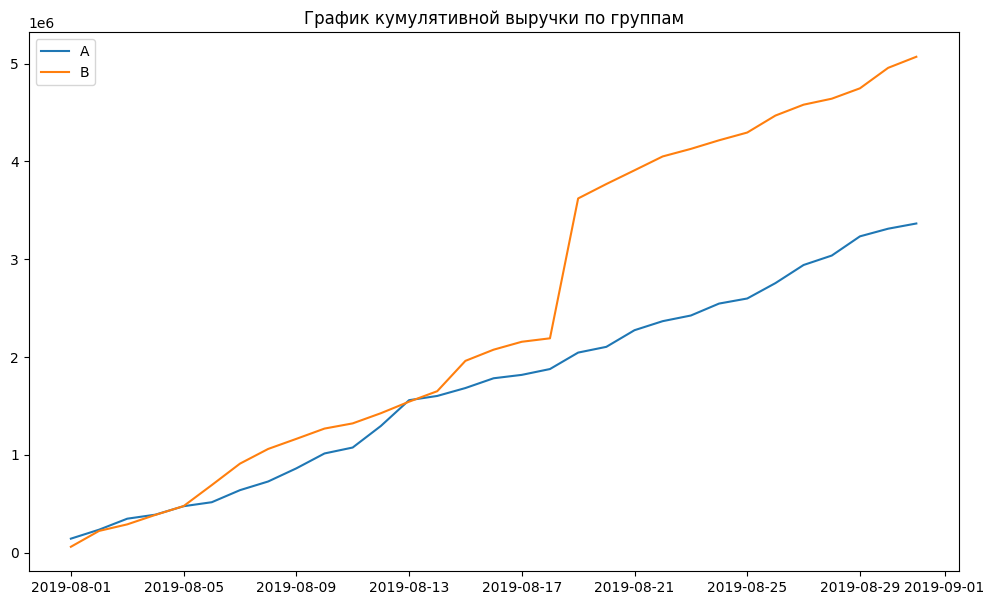

In [ ]:
plt.rcParams["figure.figsize"] = (12,7)
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
plt.title('График кумулятивной выручки по группам')
plt.legend();

Выручка группы 'B' намного превышает выручку группы 'A'. Лидировать группа начала чуть раньше середены теста. Возможно есть аномальные заказы, возможно группы поделили не 50/50 по какому-то признаку.

### 2. Построим график кумулятивного среднего чека по группам. Сделаем выводы и предположения.

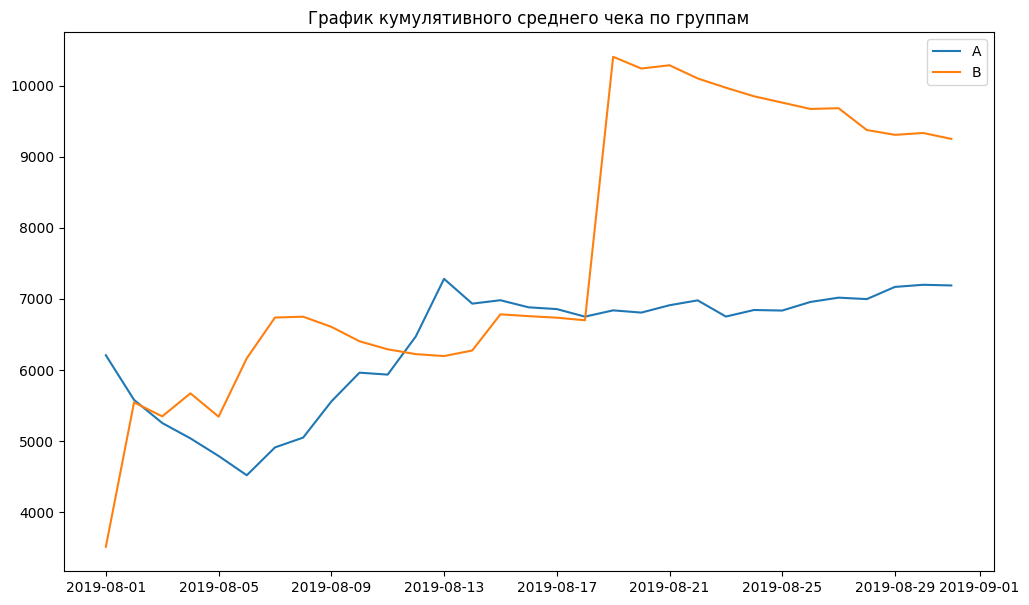

In [ ]:
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'] / cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'] / cumulative_revenue_b['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам')
plt.legend();

Где-то в середине теста средний чек в группе 'B' резко вырос, потом начал падать. Версия об аномальных заказах кажется наиболее вероятной. Прежде чем делать выводы необходимо проверить данные на аномальные заказы.

### 3. Построим график относительного изменения кумулятивного среднего чека группы B к группе A. Сделаем выводы и предположения.

In [ ]:
merge_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, left_on=['date'], right_on=['date'], how='left', suffixes=['_a', '_b'])
merge_revenue.head()

,date,revenue_a,orders_a,revenue_b,orders_b
0,2019-08-01,142779,23,59758,17
1,2019-08-02,234381,42,221801,40
2,2019-08-03,346854,66,288850,54
3,2019-08-04,388030,77,385740,68
4,2019-08-05,474413,99,475648,89


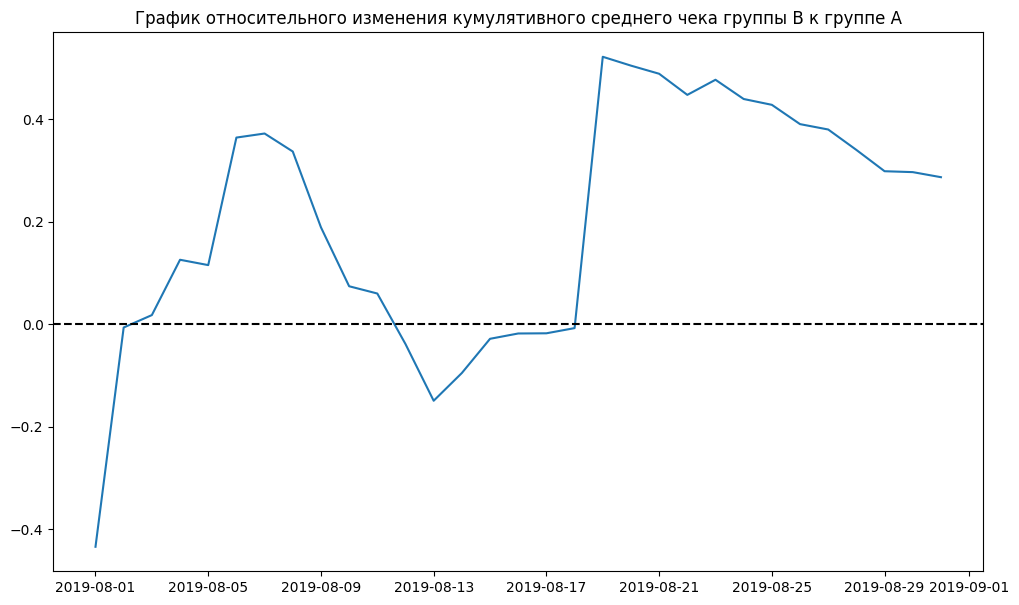

In [ ]:
plt.plot(merge_revenue['date'], (merge_revenue['revenue_b'] / merge_revenue['orders_b']) / (merge_revenue['revenue_a'] / merge_revenue['orders_a'])-1)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--');

Средний чек аномально растет и падает в несколько дат, вероятнее всего в эти даты были сделаны аномальные заказы. В большинстве времени средний чек группы 'B' больше, чем у группы 'A'.

### 4. Построим график кумулятивного среднего количества заказов на посетителя по группам. Сделаем выводы и предположения.

In [ ]:
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']
cumulative_data_a = cumulative_data[cumulative_data['group'] == 'A']
cumulative_data_b = cumulative_data[cumulative_data['group'] == 'B']

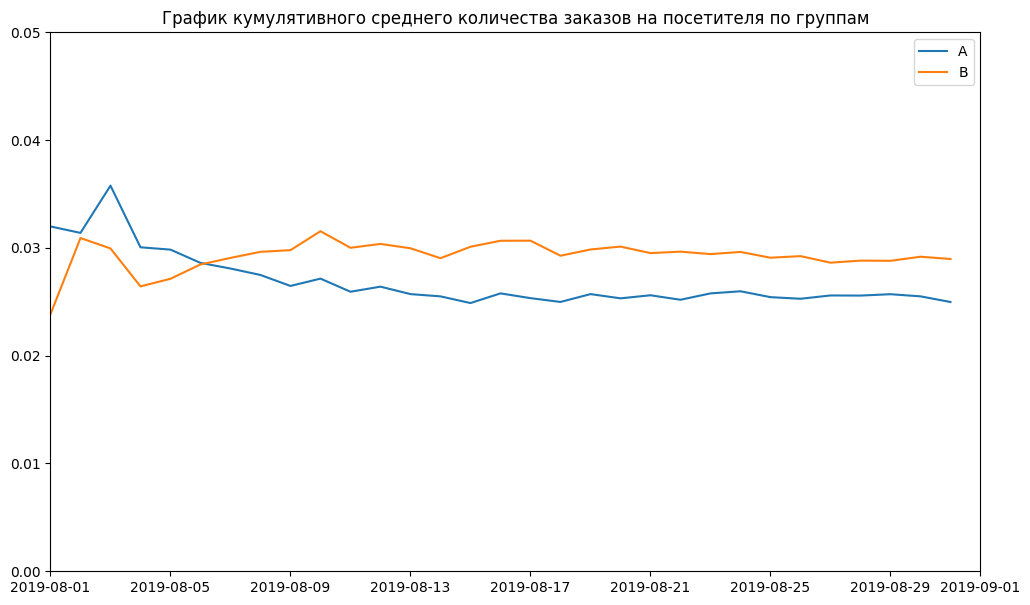

In [ ]:
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05])
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.legend();

Утсановим нужный масштаб графика, чтобы лишние колебания не мешали анализу. Видно, что конверсии вышли на "плато", конверсия 'B' практически на протяжении всего теста больше, что у 'A'.

### 5. Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделаем выводы и предположения.

In [ ]:
merge_conversion = cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date', 'conversion']], left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])
merge_conversion.head()

,date,conversion_a,conversion_b
0,2019-08-01,0.031989,0.023843
1,2019-08-02,0.031390,0.030912
2,2019-08-03,0.035772,0.029950
3,2019-08-04,0.030055,0.026428
4,2019-08-05,0.029837,0.027134


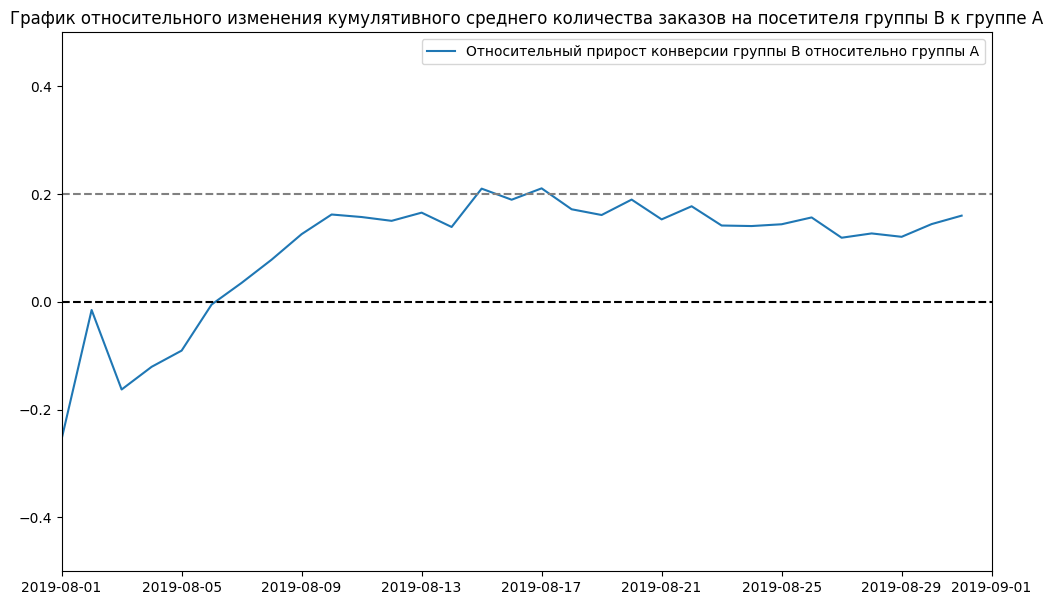

In [ ]:
plt.plot(merge_conversion['date'], merge_conversion['conversion_b'] / merge_conversion['conversion_a']-1, label = 'Относительный прирост конверсии группы B относительно группы A')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.5, 0.5])
plt.legend();

Почти с самого начала группа 'B' лидирует по конверсии, достигает своего максимума в 20% где-то в середине теста.

### 6. Построим точечный график количества заказов по пользователям. Сделаем выводы и предположения.

In [ ]:
orders_by_users = orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})
orders_by_users.columns = ['visitor_id', 'orders']
x_values = pd.Series(range(0, len(orders_by_users)))

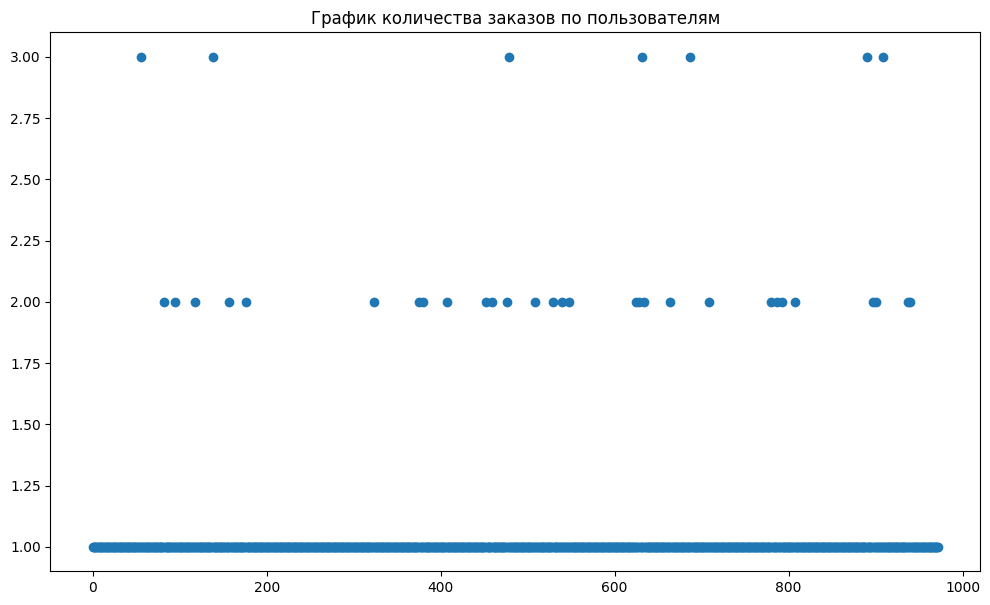

In [ ]:
plt.scatter(x_values, orders_by_users['orders'])
plt.title('График количества заказов по пользователям');

Большинство пользователей делали 1-2 заказа. Некоторые делали больше 10, это определенно аномальные значеения. Кажется, что больше 4 заказов делало мало пользователей и можно считать это значение аномальным. Проверим это в следующем шаге.

### 7. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [ ]:
np.percentile(orders_by_users['orders'], [95, 99])

array([1., 2.])

Оказалось, что 95% пользователей сделали 1 заказ, больше 2 заказов сделали лишь 1% пользователей. Возьмем за граничной значение 1. Если у пользователей больше 1 заказа, то это аномалия.

### 8. Построим точечный график стоимостей заказов. Сделаем выводы и предположения.

In [ ]:
x_value_orders = pd.Series(range(0, len(orders['revenue'])))

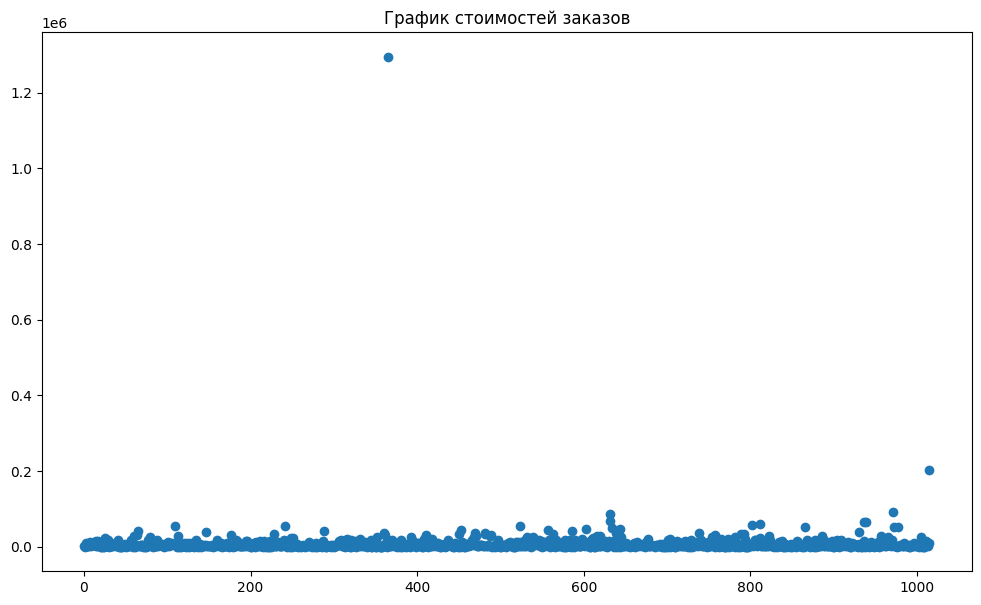

In [ ]:
plt.scatter(x_value_orders, orders['revenue'])
plt.title('График стоимостей заказов');

Практически все заказы меньше 200 000. Но выбросы присутствуют, скорее всего граница будет меньше 200 000.

### 9. Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [ ]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

Лишь 5% заказов больше 26785, но встречают и заказы больше миллиона. За границу возьмем 26785.

### 10. Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделаем выводы и предположения.

H0: различий в среднем количестве заказов на посетителя между группами по "сырым" данным нет;

H1: различия есть.

In [ ]:
orders_by_users.head()

,visitor_id,orders
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1


In [ ]:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']
visitors_a_cumulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cumulative.columns = ['date', 'visitors_a_cumulative']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

visitors_b_cumulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cumulative.columns = ['date', 'visitors_b_cumulative']


In [ ]:
orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_a_cumulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cumulative.columns = [
    'date',
    'orders_cumulative_a',
    'revenue_cummulative_a',
]

orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cumulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cumulative.columns = [
    'date',
    'orders_cumulative_b',
    'revenue_cummulative_b',
]

In [ ]:
data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cumulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cumulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cumulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cumulative, left_on='date', right_on='date', how='left')
)
data.head()

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cumulative_a,revenue_cummulative_a,orders_cumulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_a_cumulative,visitors_b_cumulative
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


In [ ]:
orders_by_users_a = orders[orders['group'] == 'A'].groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})
orders_by_users_a.columns = ['visitor_id', 'orders']
orders_by_users_b =orders[orders['group'] == 'B'].groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})
orders_by_users_b.columns = ['visitor_id', 'orders']

In [ ]:
sample_a = pd.concat([orders_by_users_a['orders'],pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')],axis=0)

sample_b = pd.concat([orders_by_users_b['orders'],pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), name='orders')],axis=0)

print("{0:.5f}".format(st.mannwhitneyu(sample_a, sample_b, alternative="two-sided")[1]))

print("{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

0.01102
0.160


p-value меньше 0.05, значит нулевую гипотезу отвергаем. Анализ "сырых" данных говорит о том, что между группами есть статистически значимые различия. Относительный прирост среднего группы 'B' к конверсии группы 'A' равен 16%.

### 11. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделаем выводы и предположения.

H0: различий в среднем чеке заказа по посетителю между группами по "сырым" данным нет;

H1: различия есть.

In [ ]:
print('{0:.3f}'.format(st.mannwhitneyu(orders[orders['group'] == 'A']['revenue'], orders[orders['group'] == 'B']['revenue'], alternative="two-sided")[1]))
print('{0:.3f}'.format(orders[orders['group'] == 'B']['revenue'].mean() / orders[orders['group'] == 'A']['revenue'].mean()-1))

0.829
0.287


p-value больше 0.05 - статистически значимых различий между средними чеками в группах нет. Относительное различие среднего чека между сегментами 28.7% - кажется, что это много.

### 12. Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделаем выводы и предположения.

H0: различий в среднем количестве заказов на посетителя между группами по "очищенным" данным нет;

H1: различия есть.

Для начала найдем id пользователей, которые считаются аномальными (Количество заказов больше 1 и заказ на сумму больше 26785).

In [ ]:
users_with_many_orders = pd.concat([
    orders_by_users_a[orders_by_users_a['orders'] > 1]['visitor_id'],
    orders_by_users_b[orders_by_users_b['orders'] > 1]['visitor_id']
], axis=0)

users_with_expensive_orders = orders[orders['revenue'] > 26785]['visitor_id']

abnormal_users = pd.concat([
    users_with_many_orders, users_with_expensive_orders
], axis=0).drop_duplicates().sort_values()

abnormal_users.head()

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: visitor_id, dtype: int64

Создадим выборки без учета аномальных пользователей.

In [ ]:
sample_a_filtered = pd.concat([
    orders_by_users_a[
        np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
    ]['orders'],
    pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])),
             name='orders',),
], axis=0,)

sample_b_filtered = pd.concat([
    orders_by_users_b[
        np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
    ]['orders'],
    pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])),
             name='orders',),
], axis=0,)

print('{0:.5f}'.format(st.mannwhitneyu(sample_a_filtered, sample_b_filtered, alternative="two-sided")[1]))
print('{0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1))

0.01593
0.174


p-value меньше 0.05, как и сырыми данными. Группа 'B' лучше группы 'A'.

### 13. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайем выводы и предположения.

H0: различий в среднем чеке заказа между группами по "очищенным" данным нет;

H1: различия есть.

In [ ]:
print(
    '{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        alternative="two-sided")[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)


0.727
-0.034


p-value больше 0.05, статистически значимых различий нет. Относительное различие между сегментами -3%, получается здесь группа 'A' показала себя лучше, чем по сырым данным (29% в пользу 'B'), причина в аномальных заказах.

### Решение по результатам теста.

В ходе исследования вяснилось, что различия между конверсиями групп есть. 13.8% по "сырым" данным, 17.4% по "очищенным". Оказалось, что и по "сырым" и по "очищенным" данным различия в средних чеках групп A и B отстутствуют, несмотря на то, что средний чек группы B оказался незначительно (на 2%) ниже среднего чека группы A по "очищенным" данным, в то время как по "сырым" данным, он был больше аж на ~26%, все дело в аномальных заказах. Это исследование напомнило как аномалии могут искажать результ, и забывать об очистке данных нельзя!

Результаты теста показали, что сегмент 'B' значительно лучше, хоть по средним сегмент 'A' лучше на 2%. Тестирование можно останавливать.